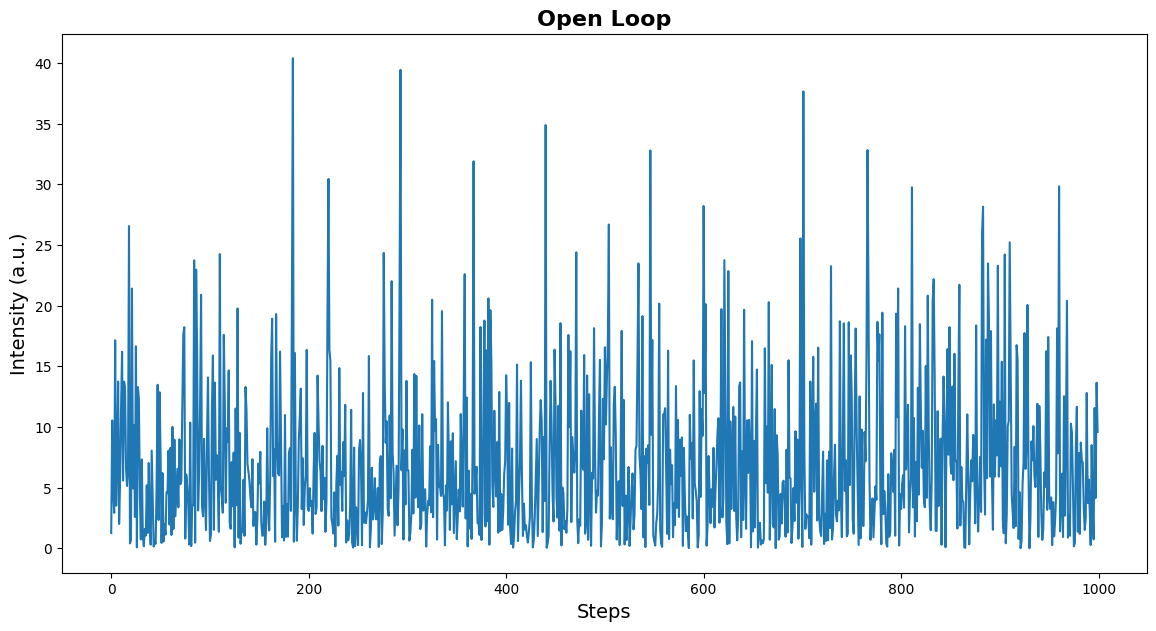

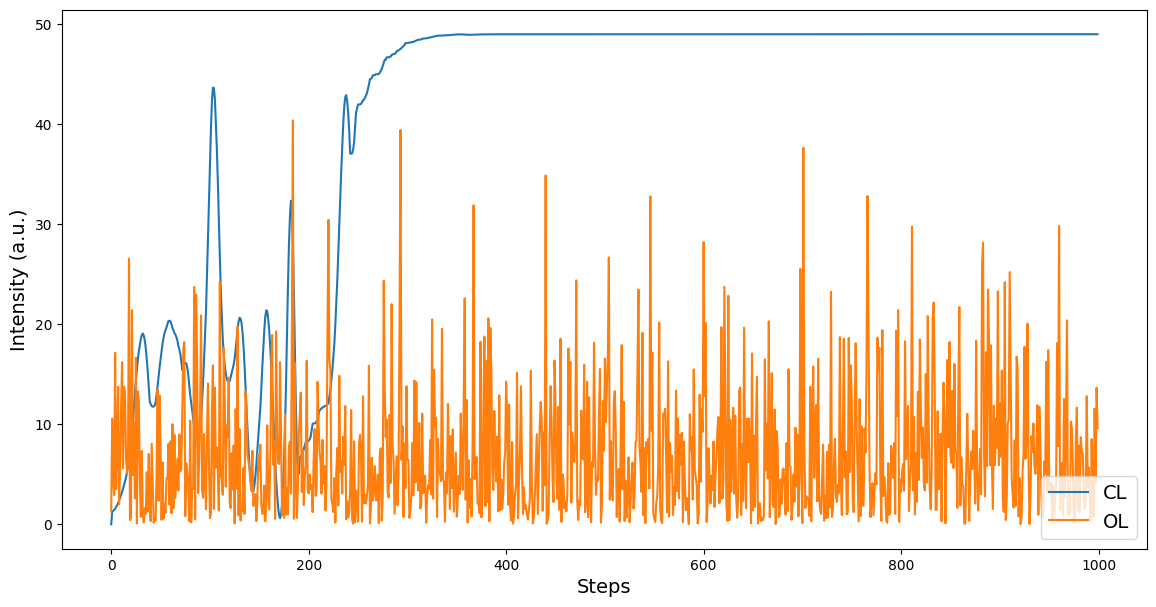

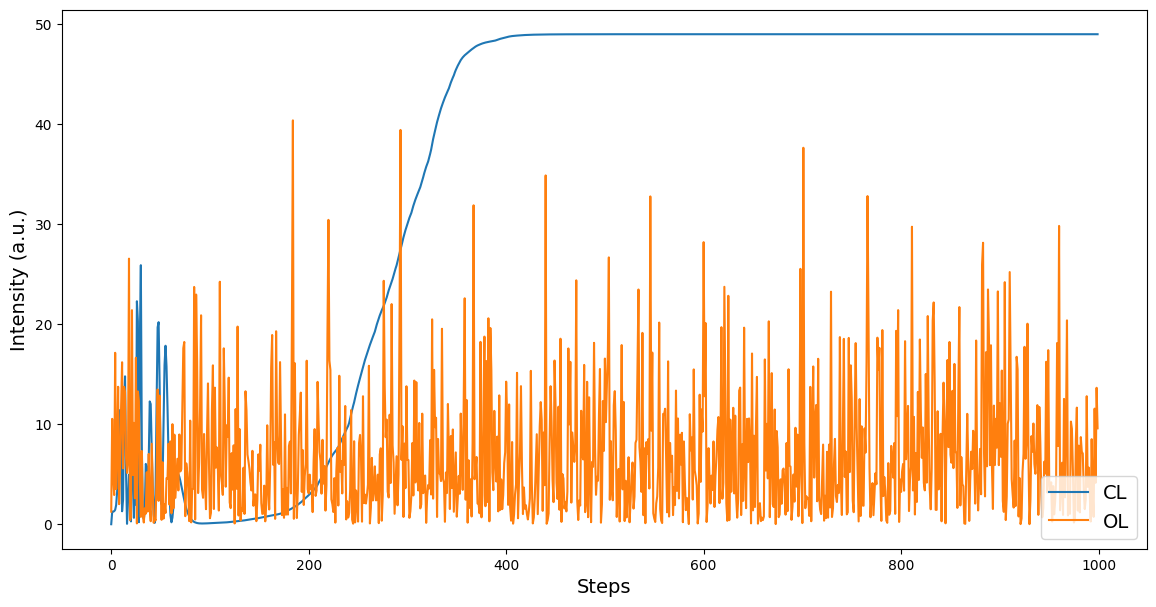

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

L = 1e3
n = 7


phi = 2 * np.pi * np.random.rand(n, int(L))


E = [np.exp(1j * phi[i]) for i in range(n)]


I = []
for i in range(int(L)):
    E_sum = np.sum([E[ch][i] for ch in range(n)])
    I.append(np.abs(np.vdot(E_sum, E_sum)))

plt.figure(figsize=(14, 7))
I = np.array(I)
plt.plot(I)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Open Loop', fontsize=16, fontweight='bold')

def mzm(E_list):
    E_sum = np.sum(E_list)
    return np.vdot(E_sum, E_sum)

def phase_mod(E, V):
    V_pi = 1.8
    phi_E = np.angle(E) + (V / V_pi) * np.pi
    return np.exp(1j * phi_E)

Gain = 0.1

V = np.ones(n) * 0.7

I_cl = np.zeros((I.shape))

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i-1], V[ch])

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.15
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 1.3- p) or np.any(V2 <= 0.3 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    V = V + p * (Ia - Ib) * Gain

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)

# Adam SPGD
Gain = 0.1189
V = np.ones(n) * 0.7
beta_1 = 0.9
beta_2 = 0.9
zeta = 1e-1

v = np.zeros(n)
s = np.zeros(n)
I_cl = np.zeros((I.shape))

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i-1], V[ch])

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 0.4 - p) or np.any(V2 <= 0.05 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    del_w = p * (Ia - Ib)

    v = (beta_1 * v + (1 - beta_1) * del_w) / (1 - beta_1 ** i)
    s = (beta_2 * s + (1 - beta_2) * (del_w ** 2)) / (1 - beta_2 ** i)

    V = V + (Gain * v) / (np.sqrt(s + zeta))

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)

plt.show()


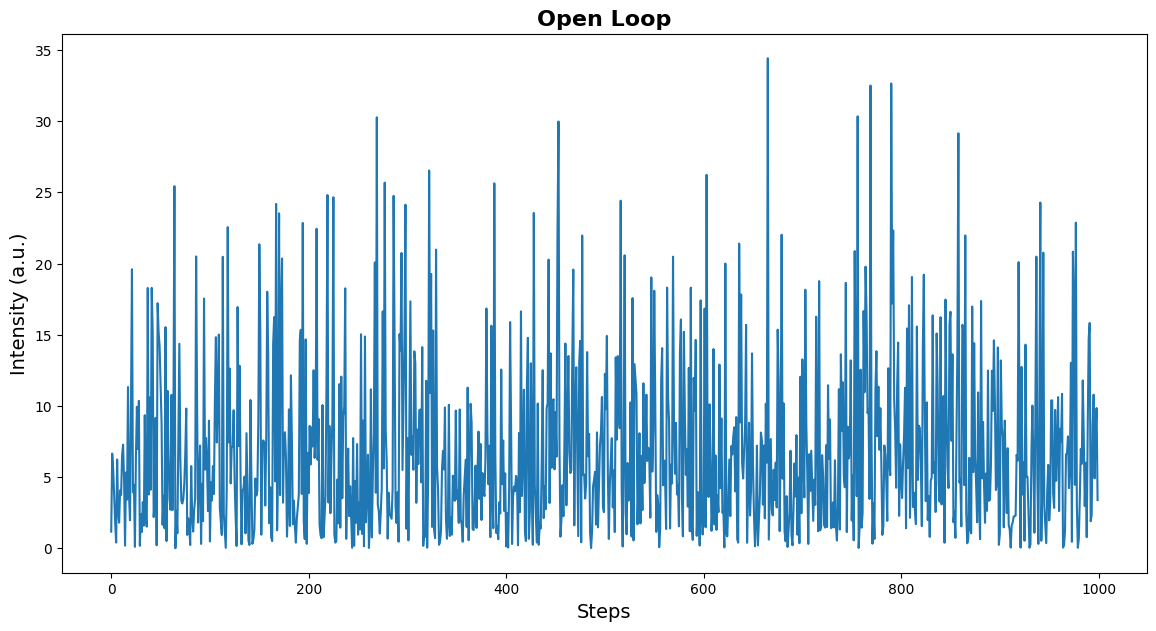

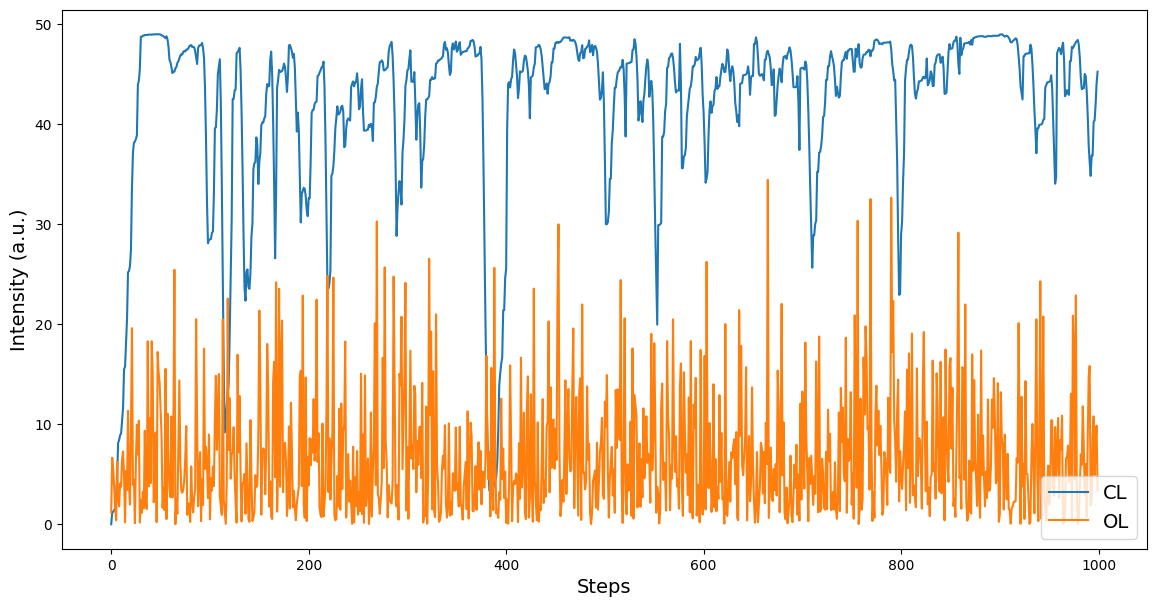

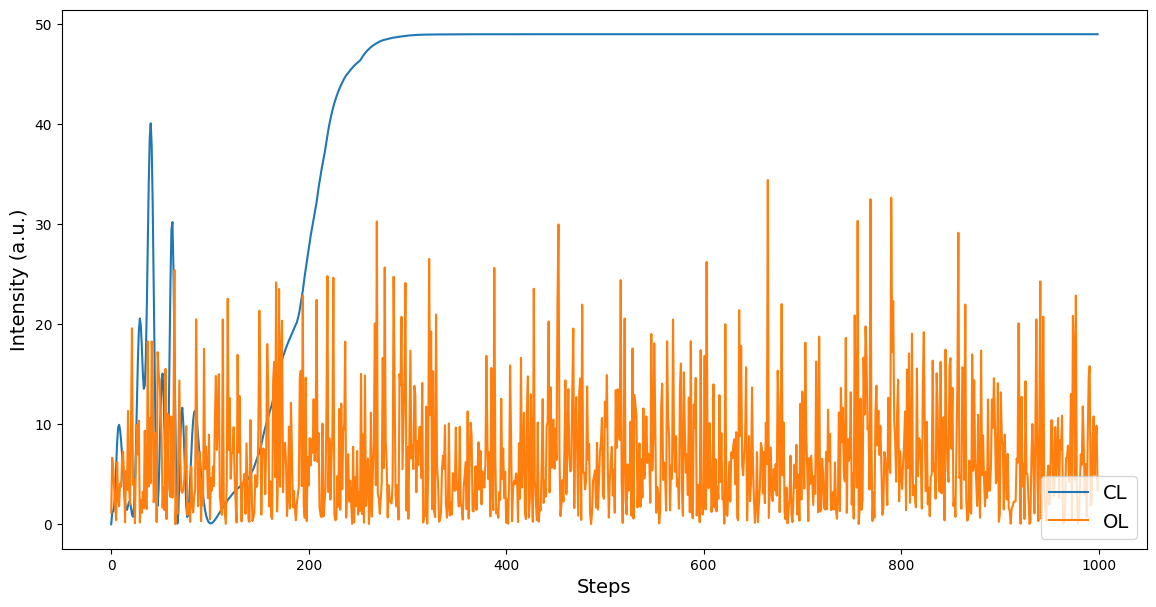

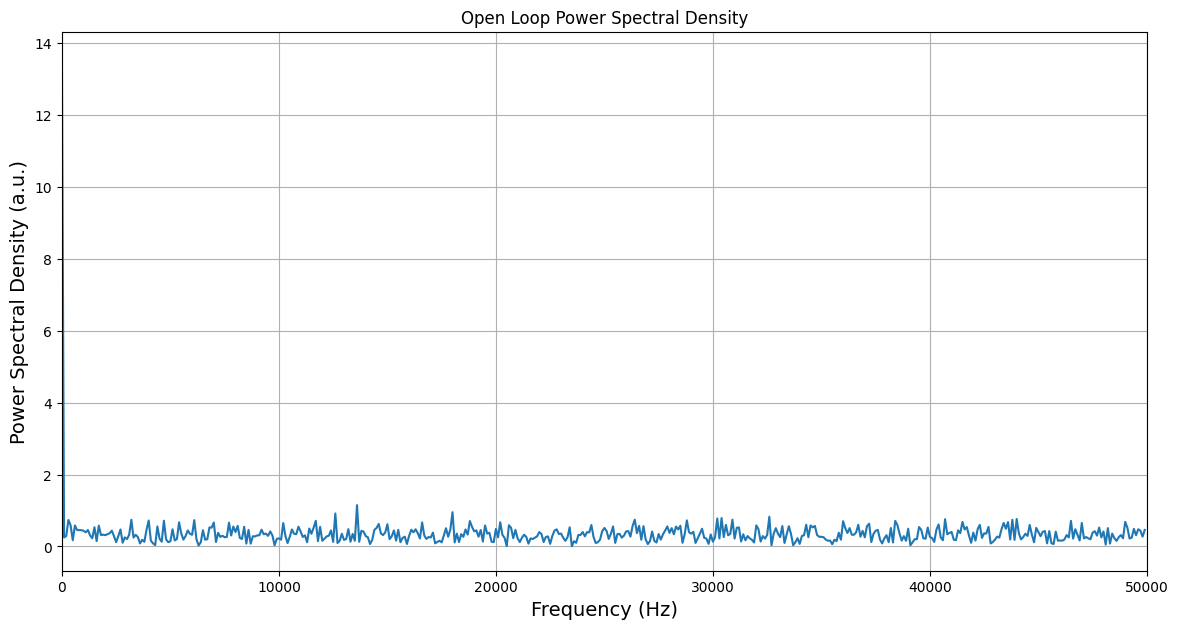

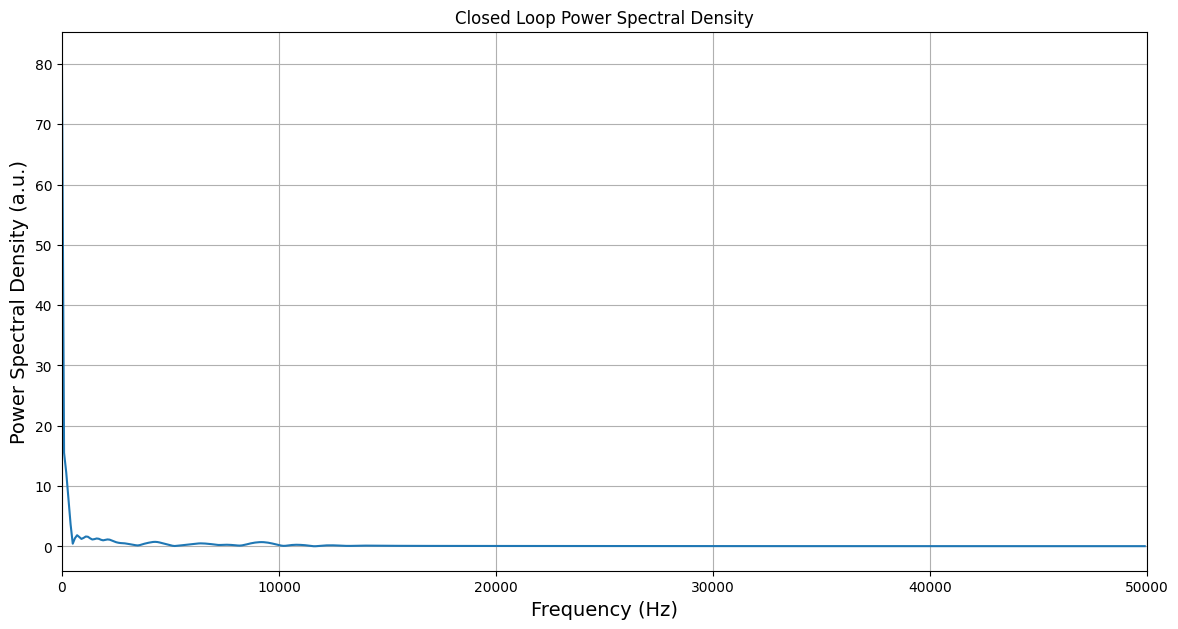

Open Loop Bandwidth: 49900.0 Hz
Closed Loop Bandwidth: 2400.0 Hz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Constants
L = 1e3
n = 7
Fs = 100000  # Sampling frequency 100 kHz to cover the 50 kHz bandwidth

# Noise parameters
noise_mean = 0
noise_std = 0.1  # Adjust the noise standard deviation as needed

# Generate random phases
phi = 2 * np.pi * np.random.rand(n, int(L))

# Compute electric field with noise
E = [np.exp(1j * (phi[i] + noise_std * np.random.randn(int(L)))) for i in range(n)]

# Compute intensity for open loop
I = []
for i in range(int(L)):
    E_sum = np.sum([E[ch][i] for ch in range(n)])
    I.append(np.abs(np.vdot(E_sum, E_sum)))

plt.figure(figsize=(14, 7))
I = np.array(I)
plt.plot(I)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Open Loop', fontsize=16, fontweight='bold')

def mzm(E_list):
    E_sum = np.sum(E_list)
    return np.vdot(E_sum, E_sum)

def phase_mod(E, V):
    V_pi = 1.8
    phi_E = np.angle(E) + (V / V_pi) * np.pi
    return np.exp(1j * phi_E)

# Closed loop parameters
Gain = 1.0  # Increased gain to target higher bandwidth
V = np.ones(n) * 0.7
I_cl = np.zeros((I.shape))

# Closed loop simulation
for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i-1], V[ch])
    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))
    p = 0.008 + np.random.rand(n) * 0.15
    V1 = V + p
    V2 = V - p
    if np.any(V1 >= 1.3 - p) or np.any(V2 <= 0.3 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p
    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]
    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))
    V = V + p * (Ia - Ib) * Gain

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)

# Adam SPGD parameters
Gain = 0.1189  # Adjusted if necessary
V = np.ones(n) * 0.7
beta_1 = 0.9
beta_2 = 0.9
zeta = 1e-1
v = np.zeros(n)
s = np.zeros(n)
I_cl = np.zeros((I.shape))

# Adam SPGD simulation with noise
for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i-1], V[ch])
    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))
    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p
    if np.any(V1 >= 0.40 - p) or np.any(V2 <= 0.1 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p
    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]
    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))
    del_w = p * (Ia - Ib)
    v = (beta_1 * v + (1 - beta_1) * del_w) / (1 - beta_1 ** i)
    s = (beta_2 * s + (1 - beta_2) * (del_w ** 2)) / (1 - beta_2 ** i)
    V = V + (Gain * v) / (np.sqrt(s + zeta))

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.show()

# Frequency domain analysis
def plot_psd(I, title):
    N = len(I)
    T = 1.0 / Fs
    yf = fft(I)
    xf = fftfreq(N, T)[:N//2]
    psd = 2.0/N * np.abs(yf[0:N//2])
    plt.figure(figsize=(14, 7))
    plt.plot(xf, psd)
    plt.grid()
    plt.title(title)
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Power Spectral Density (a.u.)', fontsize=14)
    plt.xlim(0, 50000)  # Set frequency range to 50 kHz
    plt.show()
    return xf, psd

# Plot and analyze the PSD for open-loop and closed-loop signals
xf_ol, psd_ol = plot_psd(I, 'Open Loop Power Spectral Density')
xf_cl, psd_cl = plot_psd(I_cl, 'Closed Loop Power Spectral Density')

# Determine bandwidth based on the frequency range where power is significant
def find_bandwidth(xf, psd, threshold=0.01):
    significant_indices = np.where(psd > threshold * np.max(psd))[0]
    bandwidth = xf[significant_indices[-1]] - xf[significant_indices[0]]
    return bandwidth

# Calculate bandwidths for both open-loop and closed-loop
bw_ol = find_bandwidth(xf_ol, psd_ol)
bw_cl = find_bandwidth(xf_cl, psd_cl)

print(f"Open Loop Bandwidth: {bw_ol} Hz")
print(f"Closed Loop Bandwidth: {bw_cl} Hz")


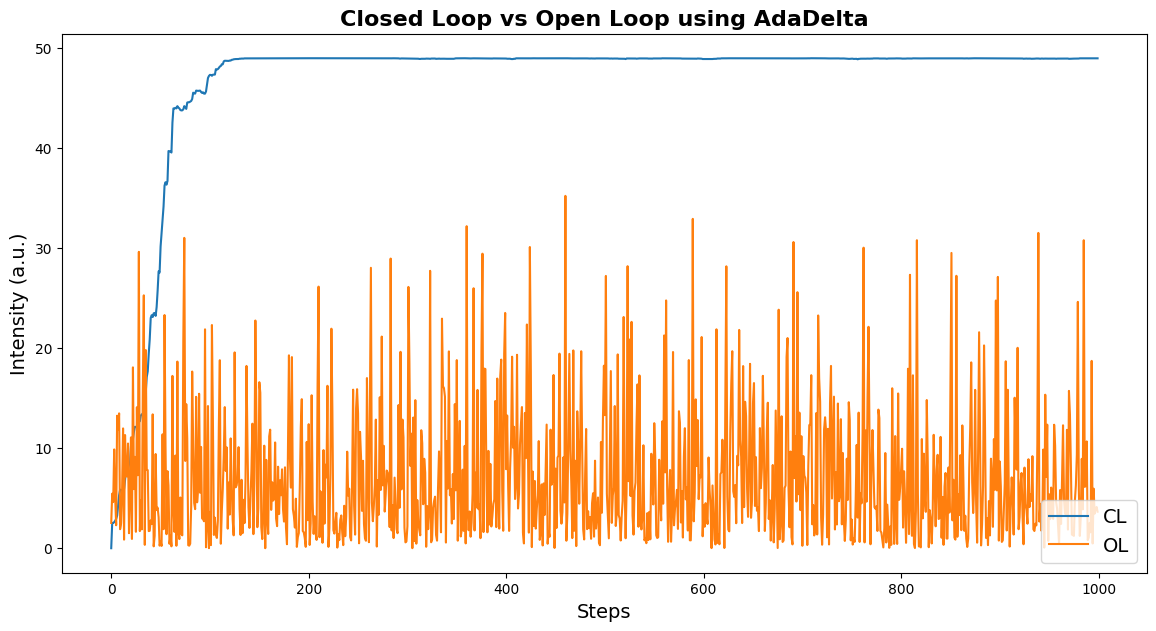

In [ ]:
# AdaDelta
Gain = 10
V = np.ones(n) * 0.7
epsilon = 1e-6  # Small constant to avoid division by zero
rho = 0.95  # Decay factor
delta_t = np.zeros(n)  # Initialize accumulated delta_t
delta_w = np.zeros(n)  # Initialize accumulated delta_w

I_cl = np.zeros((I.shape))

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i - 1], V[ch])

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 9.5 - p) or np.any(V2 <= 1 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    del_w = p * (Ia - Ib)

    delta_t = rho * delta_t + (1 - rho) * del_w ** 2  # Update accumulated delta_t
    RMS_delta_t = np.sqrt(delta_t + epsilon)  # RMS of delta_t

    RMS_delta_w = np.sqrt(delta_w + epsilon)  # RMS of delta_w
    adjusted_del_w = RMS_delta_w / RMS_delta_t * del_w  # Scale gradient by RMS(delta_w) / RMS(delta_t)

    V = V + Gain * adjusted_del_w  # Update weights
    delta_w = rho * delta_w + (1 - rho) * adjusted_del_w ** 2  # Update accumulated delta_w

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Closed Loop vs Open Loop using AdaDelta', fontsize=16, fontweight='bold')
plt.show()


In [ ]:
# AdaGrad
Gain = 5

V = np.ones(n) * 0.7
epsilon = 1e-8  # Small constant to avoid division by zero
G = np.zeros(n)  # Initialize sum of squares of gradients

I_cl = np.zeros((I.shape))

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i - 1], V[ch])

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 9.5 - p) or np.any(V2 <= 1 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    del_w = p * (Ia - Ib)

    G += del_w ** 2  # Accumulate squared gradients
    adjusted_G = np.sqrt(G + epsilon)  # Add small constant for numerical stability
    adjusted_del_w = del_w / adjusted_G  # Scale the gradient by the accumulated squared gradients

    V = V + Gain * adjusted_del_w  # Update weights

plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Closed Loop vs Open Loop using AdaGrad', fontsize=16, fontweight='bold')
plt.show()


NameError: name 'np' is not defined

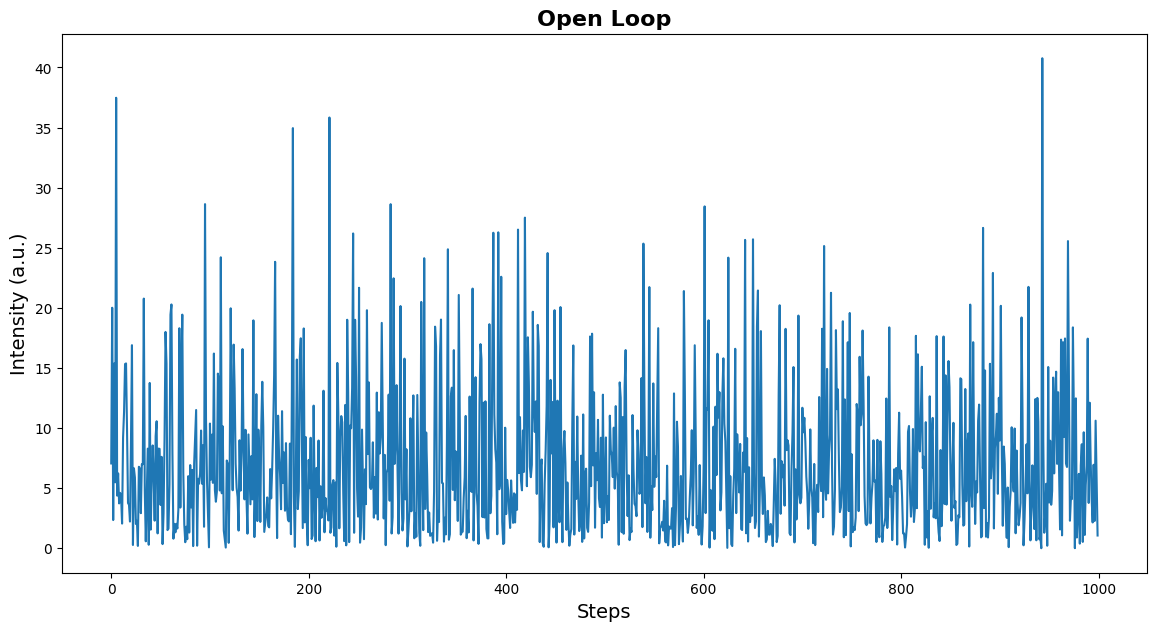

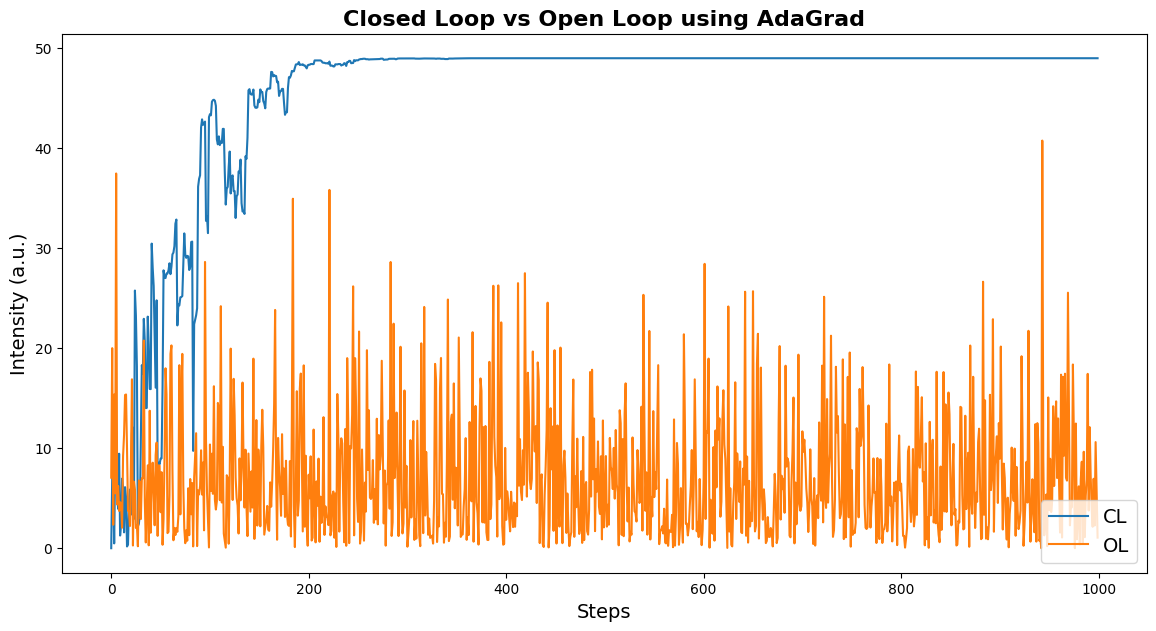

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters
L = 1e3
n = 7
phi = 2 * np.pi * np.random.rand(n, int(L))

# Generate electric field components
E = [np.exp(1j * phi[i]) for i in range(n)]

# Open loop calculation
I = []
for i in range(int(L)):
    E_sum = np.sum([E[ch][i] for ch in range(n)])
    I.append(np.abs(np.vdot(E_sum, E_sum)))

# Plot Open Loop result
plt.figure(figsize=(14, 7))
I = np.array(I)
plt.plot(I)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Open Loop', fontsize=16, fontweight='bold')

# Define functions
def mzm(E_list):
    E_sum = np.sum(E_list)
    return np.vdot(E_sum, E_sum)

def phase_mod(E, V):
    V_pi = 1.8
    phi_E = np.angle(E) + (V / V_pi) * np.pi
    return np.exp(1j * phi_E)

# AdaGrad parameters
Gain = 5
epsilon = 1e-8  # Small constant to avoid division by zero
G = np.zeros(n)  # Initialize sum of squares of gradients

# Initialize control voltages
V = np.ones(n) * 0.7

# Closed loop calculation with AdaGrad optimizer
I_cl = np.zeros((I.shape))

# Initialize lists to store phase data for polar plots
phase_data = [[] for _ in range(n)]

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i - 1], V[ch])
        # Store phase data for polar plots
        phase_data[ch].append(np.angle(E[ch][i]))

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 0.5 - p) or np.any(V2 <= 0.3 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    del_w = p * (Ia - Ib)

    G += del_w ** 2  # Accumulate squared gradients
    adjusted_G = np.sqrt(G + epsilon)  # Add small constant for numerical stability
    adjusted_del_w = del_w / adjusted_G  # Scale the gradient by the accumulated squared gradients

    V = V + Gain * adjusted_del_w  # Update weights

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Closed Loop vs Open Loop using AdaGrad', fontsize=16, fontweight='bold')
plt.show()

# # Plot polar plots for each channel
# fig, axes = plt.subplots(1, n, subplot_kw=dict(projection='polar'), figsize=(20, 4))

# for ch in range(n):
#     theta = phase_data[ch]
#     r = np.ones_like(theta)
#     axes[ch].scatter(theta, r, s=1)
#     axes[ch].set_title(f'Channel {ch+1}', fontsize=12)
#     axes[ch].set_rticks([])  # Remove radial ticks
#     axes[ch].set_yticklabels([])  # Remove radial labels

# plt.tight_layout()
# plt.show()


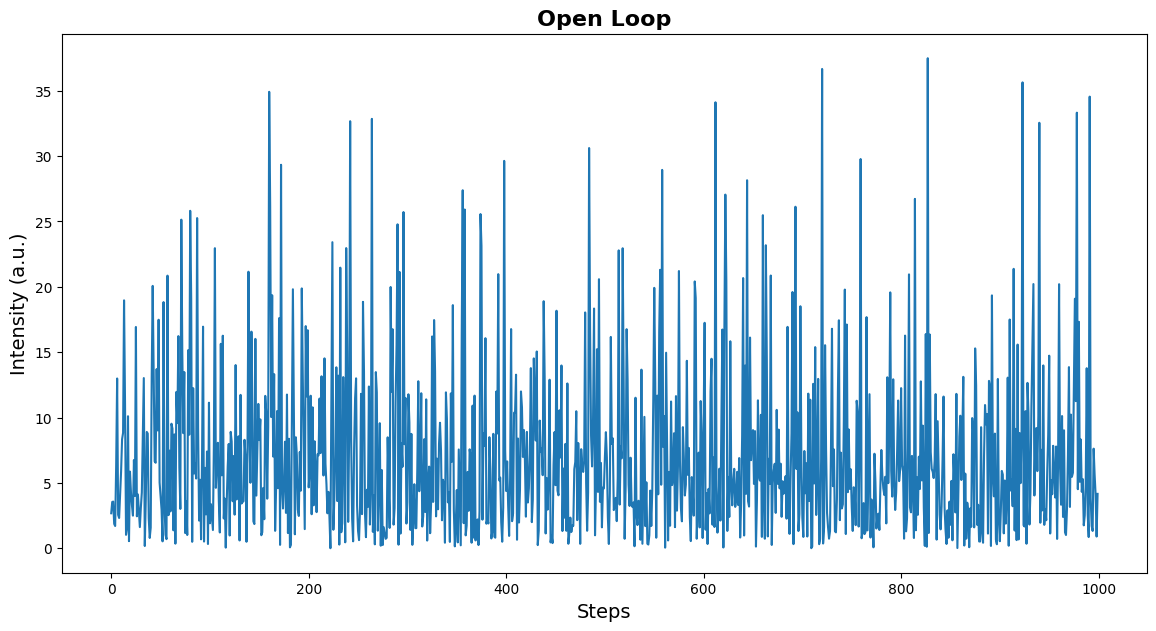

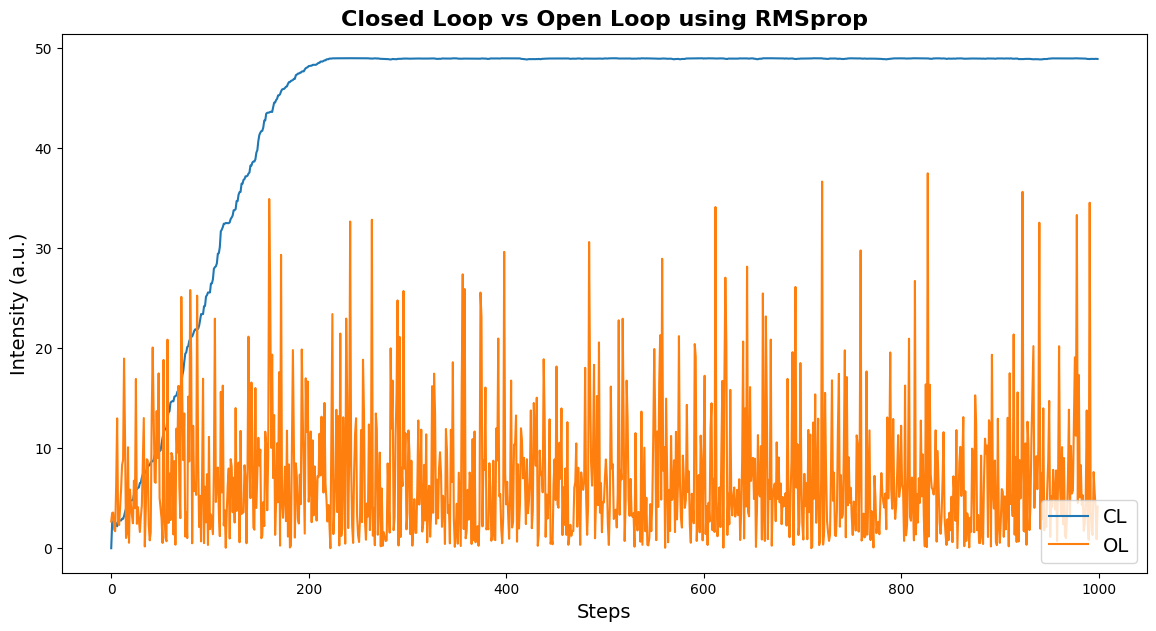

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters
L = 1e3
n = 7
phi = 2 * np.pi * np.random.rand(n, int(L))

# Generate electric field components
E = [np.exp(1j * phi[i]) for i in range(n)]

# Open loop calculation
I = []
for i in range(int(L)):
    E_sum = np.sum([E[ch][i] for ch in range(n)])
    I.append(np.abs(np.vdot(E_sum, E_sum)))

# Plot Open Loop result
plt.figure(figsize=(14, 7))
I = np.array(I)
plt.plot(I)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Open Loop', fontsize=16, fontweight='bold')

# Define functions
def mzm(E_list):
    E_sum = np.sum(E_list)
    return np.vdot(E_sum, E_sum)

def phase_mod(E, V):
    V_pi = 1.8
    phi_E = np.angle(E) + (V / V_pi) * np.pi
    return np.exp(1j * phi_E)

# RMSprop parameters
alpha = 0.03 # Learning rate
beta = 0.9  # Decay rate
epsilon = 1e-8  # Small constant to avoid division by zero
squared_gradients = np.zeros(n)  # Initialize squared gradients

# Initialize control voltages
V = np.ones(n) * 0.7

# Closed loop calculation with RMSprop optimizer
I_cl = np.zeros((I.shape))

# Initialize lists to store phase data for polar plots
phase_data = [[] for _ in range(n)]

for i in range(1, len(I)):
    for ch in range(n):
        E[ch][i] = phase_mod(E[ch][i - 1], V[ch])
        # Store phase data for polar plots
        phase_data[ch].append(np.angle(E[ch][i]))

    I_cl[i] = np.abs(mzm([E[ch][i] for ch in range(n)]))

    p = 0.008 + np.random.rand(n) * 0.1
    V1 = V + p
    V2 = V - p

    if np.any(V1 >= 0.5 - p) or np.any(V2 <= 0.01 + p):
        V = np.ones(n) * 0.6
        V1 = V + p
        V2 = V - p

    I_new_1 = [phase_mod(E[ch][i], V1[ch]) for ch in range(n)]
    I_new_2 = [phase_mod(E[ch][i], V2[ch]) for ch in range(n)]

    Ia = np.abs(mzm(I_new_1))
    Ib = np.abs(mzm(I_new_2))

    del_w = p * (Ia - Ib)

    squared_gradients = beta * squared_gradients + (1 - beta) * (del_w ** 2)  # Update squared gradients
    adjusted_del_w = del_w / (np.sqrt(squared_gradients) + epsilon)  # Scale the gradient by the RMSprop update

    V = V + alpha * adjusted_del_w  # Update weights

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(I_cl)
plt.plot(I)
plt.legend(['CL', 'OL'], fontsize=14, loc='lower right')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.title('Closed Loop vs Open Loop using RMSprop', fontsize=16, fontweight='bold')
plt.show()

